In [58]:
from adv_train.utils.logger import Database, RecordState
from adv_train.dynamic import Attacker
from adv_train.model import MnistModel
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
})

In [176]:
PATH = "/checkpoint/hberard/AdversarialTraining/logs/mnist_sweep_fgsm_2/"
db = Database(PATH)

In [196]:
_df = db.extract_to_df()

In [101]:
df = _df[
        #(results['eps_iter'] > 0.006) & (results['lr'] > 0.003) & (results['type'] == MnistModel.MODEL_A) &
        (((_df["attacker_type"] == Attacker.LANGEVIN) & (_df["eps_iter"] > 0.01) & (_df["lr"] > 0.006)) #|
        #  ((_df["attacker_type"] == Attacker.PGD_40) & (_df["eps_iter"] > 0.008) & (_df["lr"] < 0.06))
        )]
print(len(df))

58


<AxesSubplot:xlabel='fgsm', ylabel='Density'>

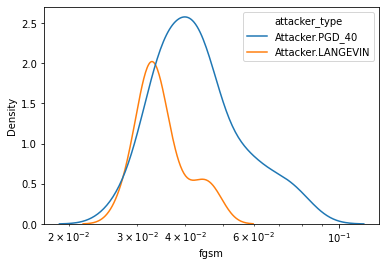

In [62]:
sns.kdeplot(data=df, hue="attacker_type", x="fgsm", clip=(-5,0), log_scale=True)

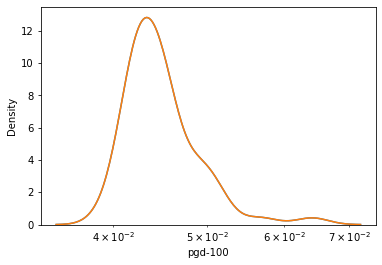

In [104]:
ax = sns.kdeplot(data=df[df["noise_scale"].between(0.001, 1.)], x="pgd-100", clip=(-5,0), log_scale=True)
ax = sns.kdeplot(data=df[df["noise_scale"].between(0.001, 1.)], x="pgd-100", clip=(-5,0), log_scale=True, ax=ax)

<AxesSubplot:xlabel='pgd-100', ylabel='Density'>

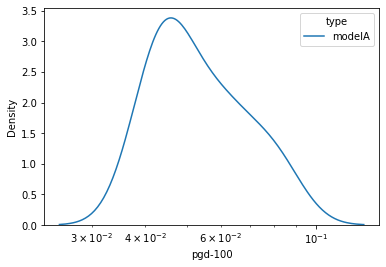

In [490]:
sns.kdeplot(data=df[df["attacker_type"]==Attacker.PGD_40], x="pgd-100", hue="type", clip=(-5,0), log_scale=True)

164


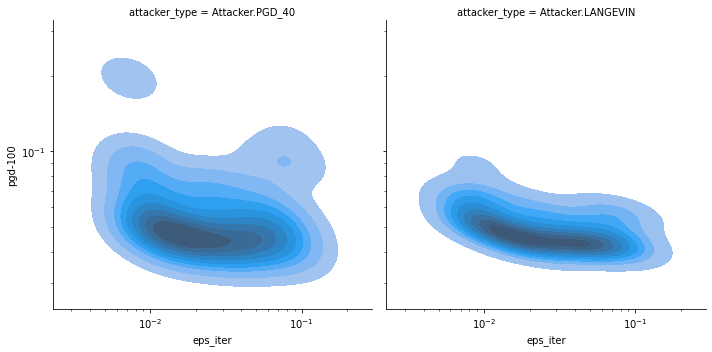

In [215]:
df = _df[(_df["type"]==MnistModel.MODEL_A) & (_df["eps_iter"] > 7e-3) & (_df["lr"] < 6e-2)]
print(len(df))
g = sns.FacetGrid(df, col="attacker_type", height=5)
g.map(sns.kdeplot, "eps_iter", "pgd-100", log_scale=True, fill=True)

<AxesSubplot:xlabel='eps_iter', ylabel='fgsm'>

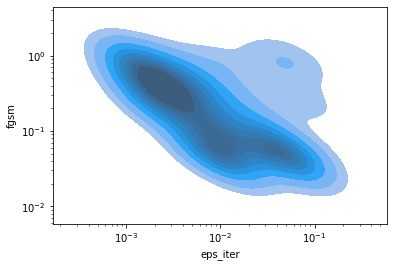

In [128]:
sns.kdeplot(x="eps_iter", y="fgsm", data=df[df["attacker_type"]==Attacker.LANGEVIN], log_scale=True, fill=True)

<AxesSubplot:xlabel='noise_scale', ylabel='pgd-100'>

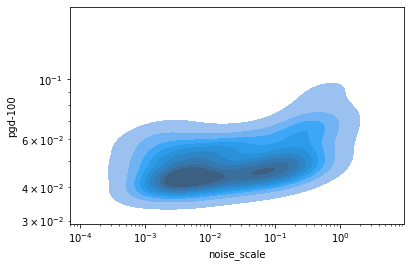

In [216]:
sns.kdeplot(x="noise_scale", y="pgd-100", data=df[df["attacker_type"]==Attacker.LANGEVIN], log_scale=True, fill=True)

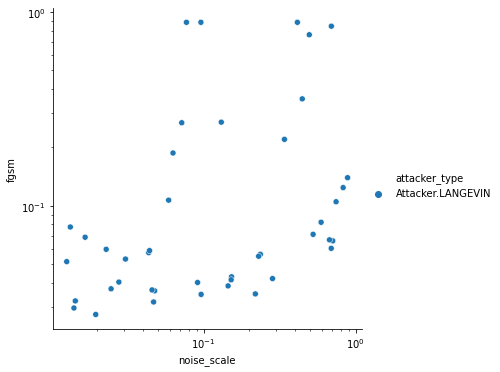

In [111]:
sns.relplot(x="noise_scale", y="fgsm", hue="attacker_type", data=df[df["attacker_type"]==Attacker.LANGEVIN])
plt.xscale("log")
plt.yscale("log")

# Plot

In [8]:
PATH = "../logs/mnist"
db = Database(PATH)

In [34]:
all_records = db.load_all_records()
print(len(all_records))
results = defaultdict(list)
for _id, record in all_records.items():
    state = record.get_state()
    if state == RecordState.EVAL_DONE:
        for key, value in record.load().items():
            if key == "num_grad":
                results[key] += list(np.cumsum(value)/60000)
            else:
                results[key] += value
        n_epochs = len(value)
        for key, value in record.load_hparams().items():
            results[key] += [value]*n_epochs
            
df = pd.DataFrame.from_dict(results)

4


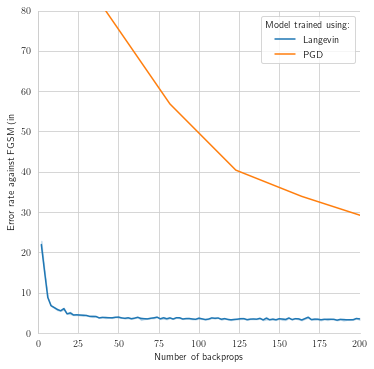

In [61]:
sns.set_style("whitegrid")
g = sns.relplot(x="num_grad", y="adv_err", hue="attacker_type", kind="line", data=df, legend=False)
plt.xlim(0, 200)
plt.ylim(0, 80)
plt.legend(title="Model trained using:", labels=['Langevin', 'PGD'])
plt.ylabel("Error rate against FGSM (in %)")
plt.xlabel("Number of backprops")
plt.savefig("../figures/fgsm_error_backprop.pdf")

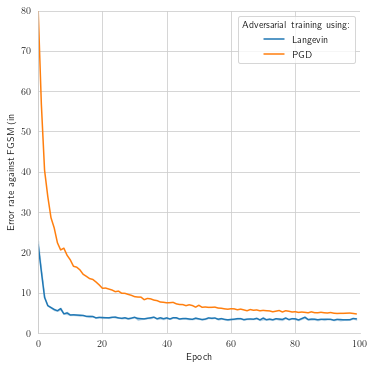

In [62]:
sns.set_style("whitegrid")
g = sns.relplot(x="epoch", y="adv_err", hue="attacker_type", kind="line", data=df, legend=False)
plt.ylim(0, 80)
plt.xlim(0, 100)
plt.legend(title="Adversarial training using:", labels=['Langevin', 'PGD'])
plt.ylabel("Error rate against FGSM (in %)")
plt.xlabel("Epoch")
plt.savefig("../figures/fgsm_error_epoch.pdf")